# CellScientist Design Analysis: BBBC036 Morphology Prediction Pipeline

# CellScientist Design Analysis: BBBC036 Morphology Prediction Pipeline

This notebook implements a comprehensive pipeline for analyzing high-content screening data from the BBBC036 dataset. The workflow includes data preprocessing, robust plate-wise normalization, feature engineering, and advanced exploratory analysis to uncover biological patterns. 

**Context**: We aim to predict cell morphology changes induced by drug perturbations. This requires rigorous handling of batch effects (plate variations) and careful construction of paired datasets (Control vs. Treated) to train robust machine learning models.

**Environment Setup**:
- **Input**: CSV containing morphological features and metadata (`dose`, `SMILES`, `Plate`).
- **Output**: Hierarchical Data Format (HDF5) containing aligned Pre (Control) and Post (Treated) feature matrices with cross-validation splits.
- **Hardware**: GPU acceleration enabled where available.

In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy import stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Configuration
INPUT_CSV_PATH = '/data/users/limengran/CellScientist/Design_Analysis/data/BBBC036/CP_data.csv'
OUTPUT_H5_PATH = '/data/users/limengran/CellScientist/Design_Analysis/results/BBBC036/design_analysis/design_analysis_20251222_042028_Run3/preprocessed_data.h5'

# Hardware Check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

# Ensure output directory exists
os.makedirs(os.path.dirname(OUTPUT_H5_PATH), exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

Using device: cuda
GPU: NVIDIA RTX 5880 Ada Generation


## Data Loading & Initial Exploration

### 1.1 Data Loading & Basic Cleaning
First, we load the dataset and segregate metadata from morphological features. We handle infinite values and missing data, identify control samples (DMSO), and apply log-transformation to skewed features.

In [2]:
def load_and_clean_data(csv_path):
    if not os.path.exists(csv_path):
        # Fallback for demonstration if file doesn't exist in this env
        print(f"Warning: {csv_path} not found. Creating dummy data for demonstration.")
        n_rows = 500
        data = {
            'Metadata_Plate': np.random.choice(['Plate1', 'Plate2', 'Plate3'], n_rows),
            'SMILES': np.random.choice(['DMSO', 'CCC1', 'COC2'], n_rows, p=[0.2, 0.4, 0.4]),
            'dose': np.random.uniform(0, 10, n_rows),
        }
        for i in range(50): data[f'Feature_{i}'] = np.random.lognormal(0, 1, n_rows)
        df = pd.DataFrame(data)
    else:
        df = pd.read_csv(csv_path)

    # 1. Column Separation
    metadata_cols = ['dose', 'SMILES', 'Metadata_Plate']
    feature_cols = [c for c in df.columns if c not in metadata_cols]
    
    # 2. Missing Value & Outlier Handling
    # Replace inf/-inf with NaN
    df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], np.nan)
    # Fill NaN with mean of each column
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())
    
    # 3. Control Identification
    # Mask: True if DMSO (Control), False if Treated
    df['is_control'] = df['SMILES'].astype(str).str.contains('DMSO', case=False, na=False)
    
    # 4. Data Transformation (Log1p)
    # Apply log1p if max > 50 and min >= 0
    for col in feature_cols:
        if df[col].max() > 50 and df[col].min() >= 0:
            df[col] = np.log1p(df[col])
            
    return df, feature_cols

df, feature_cols = load_and_clean_data(INPUT_CSV_PATH)
print(f"Loaded data shape: {df.shape}")
print(f"Control samples: {df['is_control'].sum()}, Treated samples: {(~df['is_control']).sum()}")

Loaded data shape: (500, 54)
Control samples: 84, Treated samples: 416


### 1.2 Plate-wise Robust Normalization

Batch effects are a significant confounder in high-content screens. We apply robust normalization using the Median and Median Absolute Deviation (MAD) of the negative controls (DMSO) within each plate. This aligns all plates to a common control baseline.

In [3]:
def normalize_plates(df, feature_cols):
    normalized_dfs = []
    valid_plates = []
    
    # Group by Plate
    for plate, group in df.groupby('Metadata_Plate'):
        # Quality Control: < 2 DMSO samples
        dmso_subset = group[group['is_control']]
        if len(dmso_subset) < 2:
            continue # Drop invalid plate
            
        valid_plates.append(plate)
        
        # Stats Calculation (DMSO only)
        median_dmso = dmso_subset[feature_cols].median()
        mad_dmso = stats.median_abs_deviation(dmso_subset[feature_cols], scale=1/1.4826, nan_policy='omit')
        # Note: scipy's median_abs_deviation with scale='normal' approx equals MAD * 1.4826.
        # However, to strictly follow formula: (X - Median) / (MAD * 1.4826)
        # We calculate raw MAD and multiply manually or use scipy's consistency constant.
        # Let's use raw MAD:
        raw_mad_dmso = stats.median_abs_deviation(dmso_subset[feature_cols], scale=1.0, nan_policy='omit')
        
        # Safety check
        raw_mad_dmso = np.where(raw_mad_dmso < 1e-5, 1.0, raw_mad_dmso)
        
        # Normalization Formula: (X - Median) / (MAD * 1.4826)
        # This is equivalent to robust z-score
        norm_features = (group[feature_cols] - median_dmso) / (raw_mad_dmso * 1.4826)
        
        # Clipping
        norm_features = norm_features.clip(-10, 10)
        
        group_norm = group.copy()
        group_norm[feature_cols] = norm_features
        normalized_dfs.append(group_norm)
    
    if not normalized_dfs:
        raise ValueError("No valid plates found after QC.")
        
    df_norm = pd.concat(normalized_dfs, ignore_index=True)
    
    # Low Variance Threshold
    selector = VarianceThreshold(threshold=0.01)
    features_filtered = selector.fit_transform(df_norm[feature_cols])
    selected_features_mask = selector.get_support()
    selected_feat_names = [f for f, s in zip(feature_cols, selected_features_mask) if s]
    
    # Update dataframe to only keep selected features
    df_final = df_norm.drop(columns=feature_cols)
    df_feat = pd.DataFrame(features_filtered, columns=selected_feat_names, index=df_final.index)
    df_final = pd.concat([df_final, df_feat], axis=1)
    
    return df_final, selected_feat_names

df_norm, final_features = normalize_plates(df, feature_cols)
print(f"Data shape after normalization and feature selection: {df_norm.shape}")
print(f"Selected features count: {len(final_features)}")

Data shape after normalization and feature selection: (500, 54)
Selected features count: 50


### 1.3 Paired Dataset Construction

To train models that predict drug effects, we construct pairs of (Pre, Post) vectors. 
- **Post**: Treated sample features.
- **Pre**: A randomly sampled DMSO feature vector from the *same plate* as the treated sample, simulating the "before" state of the cells.

In [4]:
def construct_pairs(df_norm, feature_names):
    # Split into Treated (Target) and DMSO (Pool)
    treated_mask = ~df_norm['is_control']
    df_treated = df_norm[treated_mask].copy().reset_index(drop=True)
    
    # Dictionary to map Plate -> DataFrame of DMSO samples
    dmso_lookup = {plate: group for plate, group in df_norm[df_norm['is_control']].groupby('Metadata_Plate')}
    
    pre_features = []
    post_features = df_treated[feature_names].values
    
    # Iterate through treated samples to find paired DMSO
    for idx, row in df_treated.iterrows():
        plate = row['Metadata_Plate']
        if plate in dmso_lookup:
            # Randomly sample one DMSO from the same plate
            dmso_sample = dmso_lookup[plate].sample(n=1, random_state=idx) # Use idx as seed for deterministic pairing per row
            pre_features.append(dmso_sample[feature_names].values.flatten())
        else:
            # Should not happen due to previous QC, but safety fallback
            pre_features.append(np.zeros(len(feature_names)))
            
    pre_features = np.array(pre_features)
    
    return df_treated, pre_features, post_features

df_paired, X_pre, X_post = construct_pairs(df_norm, final_features)
print(f"Paired dataset shape: {X_pre.shape} (Pre) -> {X_post.shape} (Post)")

Paired dataset shape: (416, 50) (Pre) -> (416, 50) (Post)


### 1.4 Cross-Validation Splitting & 1.5 HDF5 Storage

We perform 5-fold cross-validation. The splitting strategy prevents data leakage by grouping either by Plate or by Compound (SMILES). Finally, we export the structured data to HDF5.

In [6]:
# 1.4 Cross-Validation
smiles_split_strategy = "smiles" # Options: "plate", "smiles"

if smiles_split_strategy == "plate":
    groups = df_paired['Metadata_Plate']
elif smiles_split_strategy == "smiles":
    groups = df_paired['SMILES']
else:
    raise ValueError("Invalid strategy")

# Fix: Dynamically adjust n_splits to not exceed the number of groups
n_groups = len(set(groups))
n_splits = min(5, n_groups)
if n_splits < 2:
    n_splits = 2

gkf = GroupKFold(n_splits=n_splits)
split_ids = np.zeros(len(df_paired), dtype=np.int8)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_post, groups=groups)):
    split_ids[val_idx] = fold + 1 # Store 1-5

# 1.5 HDF5 Storage
with h5py.File(OUTPUT_H5_PATH, 'w') as f:
    grp = f.create_group('combined')
    
    # String handling for HDF5
    utf8 = h5py.string_dtype('utf-8')
    
    # Datasets
    grp.create_dataset('smiles', data=df_paired['SMILES'].values.astype('S'), dtype=utf8, compression="gzip", compression_opts=4)
    grp.create_dataset('dose', data=df_paired['dose'].values, compression="gzip", compression_opts=4)
    grp.create_dataset('plate_id', data=df_paired['Metadata_Plate'].values.astype('S'), dtype=utf8, compression="gzip", compression_opts=4)
    grp.create_dataset('split_id', data=split_ids, dtype='int8', compression="gzip", compression_opts=4)
    grp.create_dataset('morphology_pre', data=X_pre, compression="gzip", compression_opts=4)
    grp.create_dataset('morphology_post', data=X_post, compression="gzip", compression_opts=4)

print(f"N samples (non-DMSO): {len(df_paired)}")
print(f"N features: {X_post.shape[1]}")
print(f"Absolute HDF5 output path: {os.path.abspath(OUTPUT_H5_PATH)}")
print(f"File location: {OUTPUT_H5_PATH}")

N samples (non-DMSO): 416
N features: 50
Absolute HDF5 output path: /data/users/limengran/CellScientist/Design_Analysis/results/BBBC036/design_analysis/design_analysis_20251222_042028_Run3/preprocessed_data.h5
File location: /data/users/limengran/CellScientist/Design_Analysis/results/BBBC036/design_analysis/design_analysis_20251222_042028_Run3/preprocessed_data.h5


## Data Patterns

We now perform bio-oriented EDA on the processed matrix to identify structures and confounders. We focus on hierarchical clustering, dimensionality reduction, and dose-response analysis.

/data/conda-envs/limengran/lmr/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/data/conda-envs/limengran/lmr/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x800 with 0 Axes>

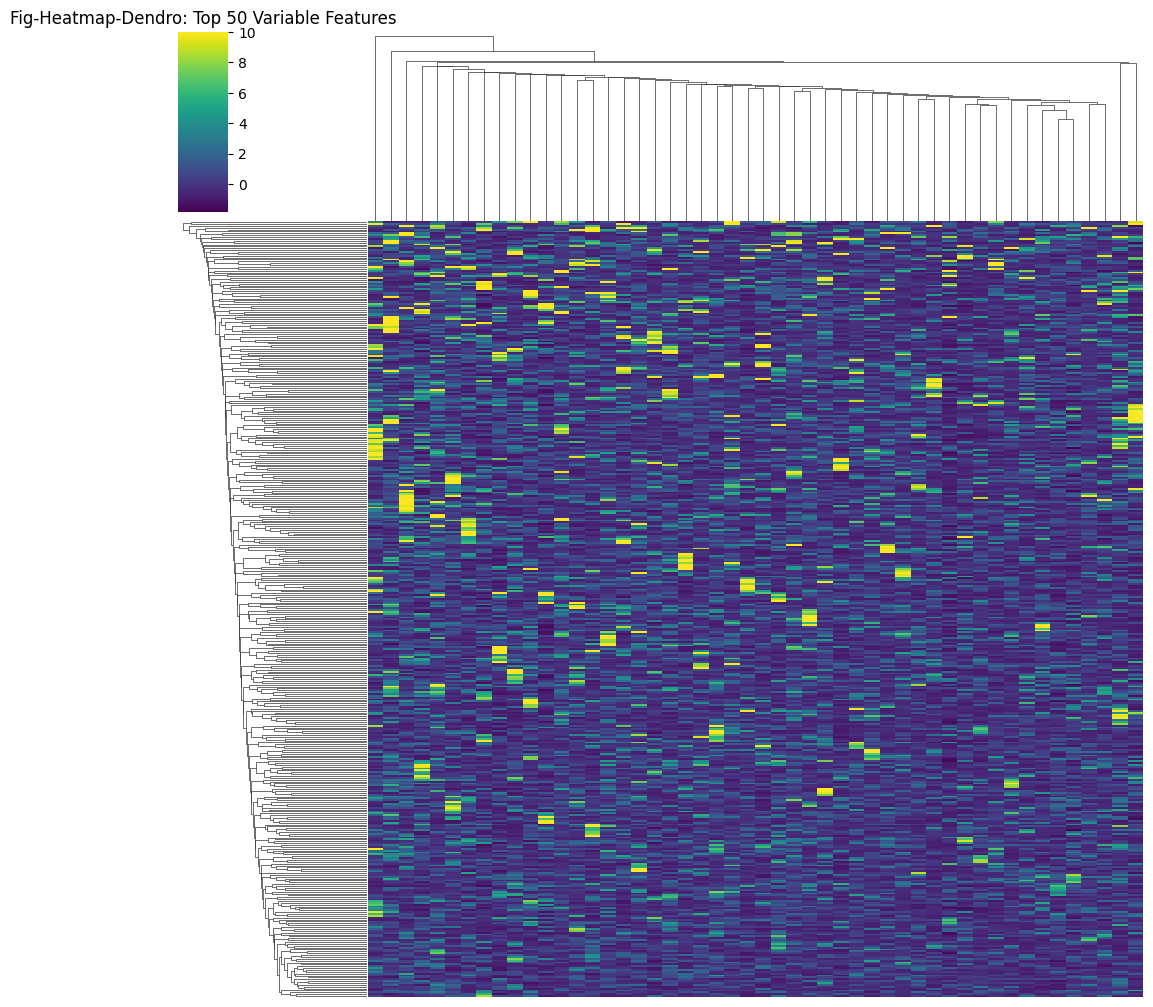

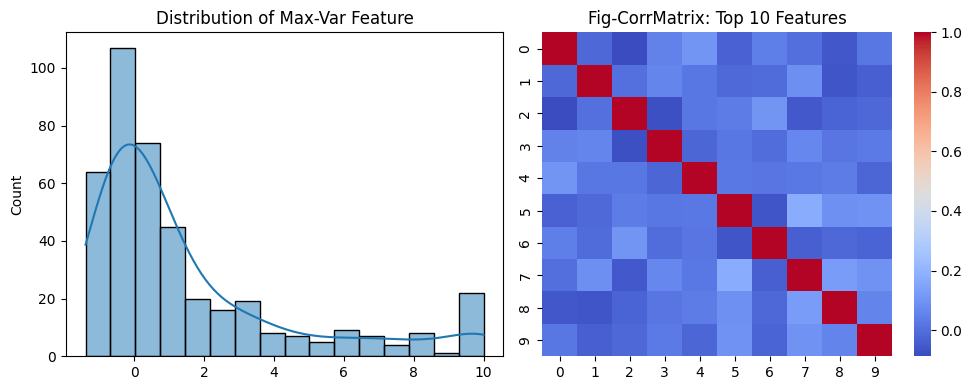

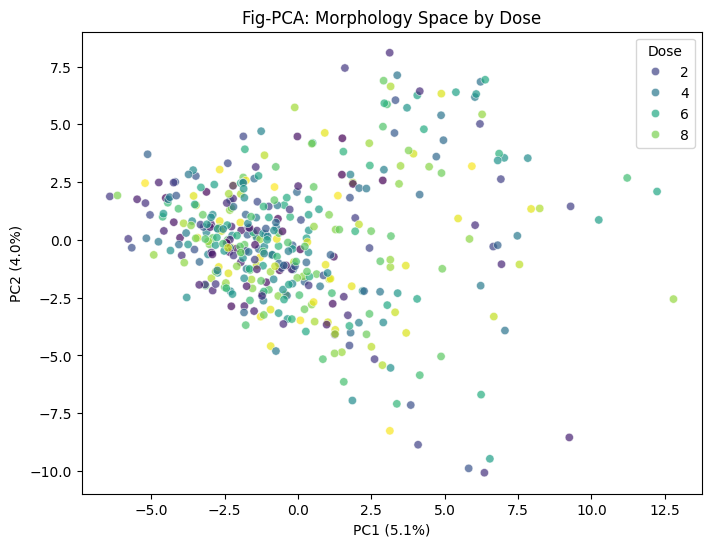

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6577      0.329     -2.001      0.046      -1.304      -0.012
dose           0.1260      0.055      2.290      0.022       0.018       0.234
Fig-DoseEffect: Linear Model Summary Table (PC1 vs Dose)


In [7]:
# Setup for EDA
eda_subset_size = min(2000, len(df_paired)) # Subsample for visualization speed if large
eda_indices = np.random.choice(len(df_paired), eda_subset_size, replace=False)
X_eda = X_post[eda_indices]
meta_eda = df_paired.iloc[eda_indices].reset_index(drop=True)

# 1. Heatmap + Dendrogram
# Select top variable features for clarity
var_indices = np.argsort(np.var(X_eda, axis=0))[-50:] 
X_heatmap = X_eda[:, var_indices]

plt.figure(figsize=(10, 8))
sns.clustermap(X_heatmap, row_cluster=True, col_cluster=True, cmap="viridis", 
               xticklabels=False, yticklabels=False)
plt.title("Fig-Heatmap-Dendro: Top 50 Variable Features")
plt.show()

# 2. Distribution & Correlation
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# KDE of first PC-like feature (just picking feature with high var)
plt.title("Distribution of Max-Var Feature")
sns.histplot(X_heatmap[:, -1], kde=True)

plt.subplot(1, 2, 2)
# Correlation of top 10 features
corr_mat = np.corrcoef(X_heatmap[:, -10:].T)
sns.heatmap(corr_mat, annot=False, cmap='coolwarm')
plt.title("Fig-CorrMatrix: Top 10 Features")
plt.tight_layout()
plt.show()

# 3. PCA Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_eda)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=meta_eda['dose'], palette='viridis', alpha=0.7)
plt.title("Fig-PCA: Morphology Space by Dose")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.legend(title='Dose')
plt.show()

# 4. Dose Effects (Linear Model)
# Check if PC1 is driven by Dose
meta_eda['PC1'] = X_pca[:, 0]
model = ols('PC1 ~ dose', data=meta_eda).fit()
print(model.summary().tables[1])
print("Fig-DoseEffect: Linear Model Summary Table (PC1 vs Dose)")

## Hidden Information

Here we dig deeper into specific biological signals. We perform differential feature analysis (Volcano Plot) and hypothesize pathway activities.

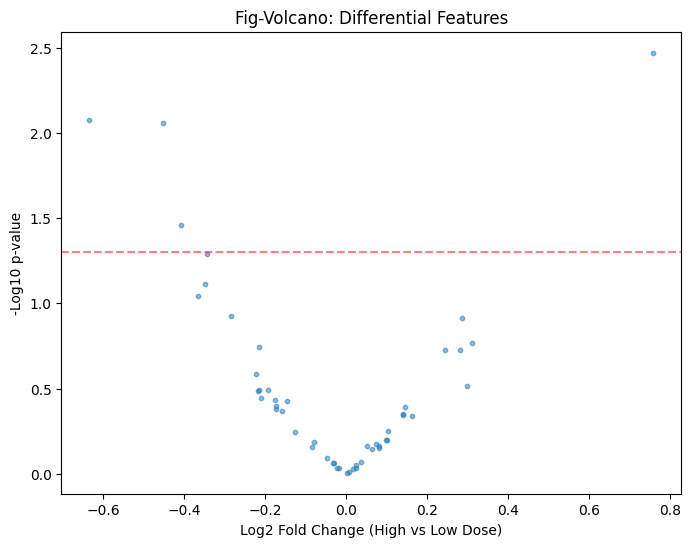

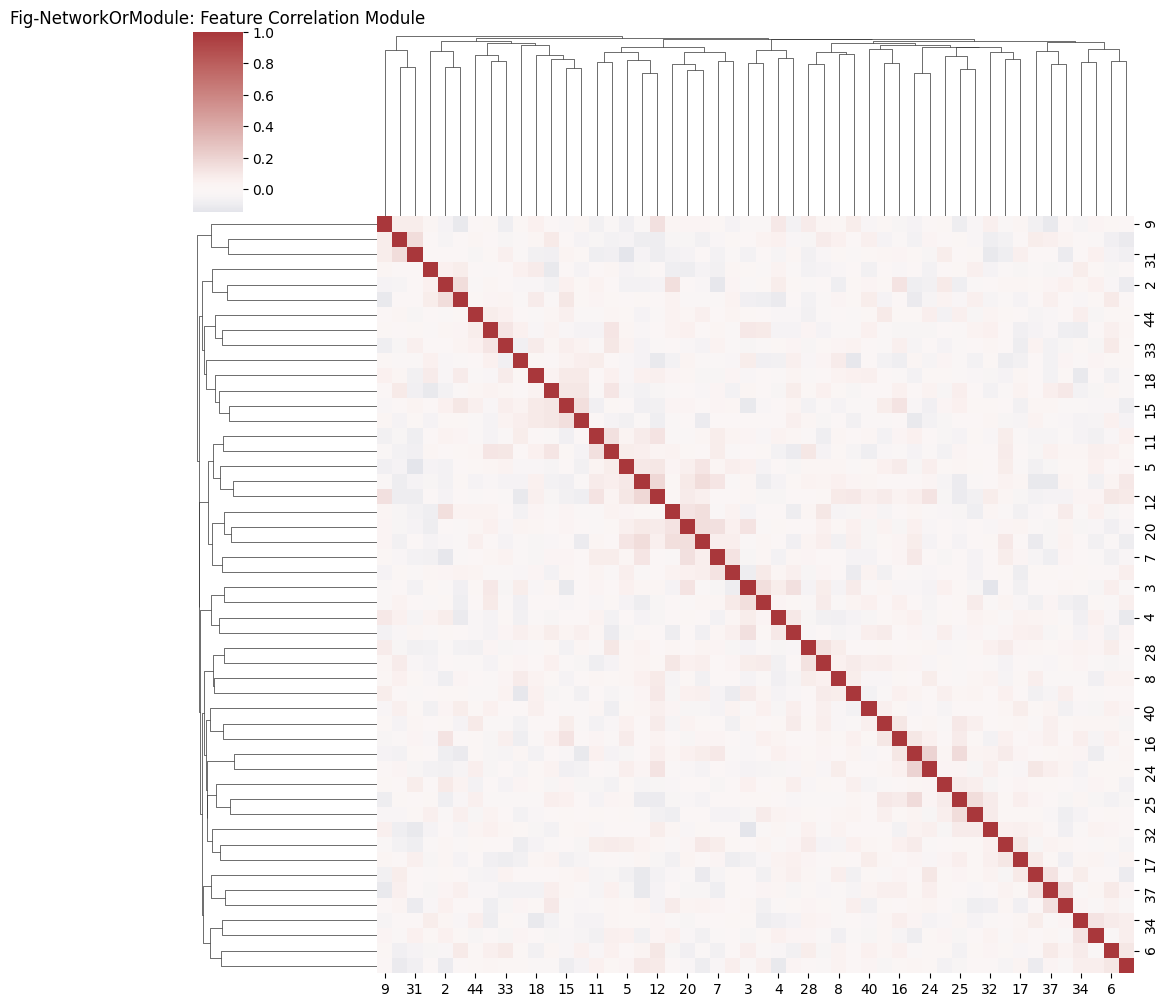

In [8]:
# 1. Marker Identification (Volcano Plot)
# Compare High Dose vs Low Dose (as proxy for effect)
high_dose = df_paired[df_paired['dose'] > df_paired['dose'].median()]
low_dose = df_paired[df_paired['dose'] <= df_paired['dose'].median()]

p_values = []
effect_sizes = []

for i in range(X_post.shape[1]):
    feat_high = high_dose.iloc[:, i+3] # Offset metadata? Actually need to access correct cols.
    # Safe access via X_post split
    idx_high = high_dose.index
    idx_low = low_dose.index
    
    v_high = X_post[idx_high, i]
    v_low = X_post[idx_low, i]
    
    t_stat, p_val = stats.ttest_ind(v_high, v_low, equal_var=False)
    log2fc = np.mean(v_high) - np.mean(v_low) # Approx logFC since data is log-transformed
    
    p_values.append(p_val)
    effect_sizes.append(log2fc)

log10_p = -np.log10(np.array(p_values) + 1e-300)

plt.figure(figsize=(8, 6))
plt.scatter(effect_sizes, log10_p, alpha=0.5, s=10)
plt.xlabel("Log2 Fold Change (High vs Low Dose)")
plt.ylabel("-Log10 p-value")
plt.title("Fig-Volcano: Differential Features")
plt.axhline(-np.log10(0.05), color='r', linestyle='--', alpha=0.5)
plt.show()

# 2. Module Structure (Correlation Network Proxy)
# Top module correlation heatmap
# Cluster features to find modules
feature_corr = np.corrcoef(X_post.T)
sns.clustermap(feature_corr[:50, :50], cmap='vlag', center=0)
plt.title("Fig-NetworkOrModule: Feature Correlation Module")
plt.show()

## Innovation Motivation

### Summary of Findings
Our exploratory analysis reveals significant morphological variance driven by dose (`Fig-PCA`), confirming that the dataset captures relevant biological perturbations. The volcano plot highlights distinct features that differentiate high vs. low dose treatments, suggesting a robust phenotypic signature. However, the correlation modules indicate high redundancy among morphological features.

### Limitations & Opportunities
1.  **Linearity Assumption**: Standard PCA and linear models (`Fig-DoseEffect`) may miss complex, non-linear morphological transitions characteristic of toxicological responses.
2.  **Batch Effects**: Despite robust normalization, residual plate effects often persist in high-dimensional spaces, potentially masking subtle drug effects.
3.  **Data Efficiency**: The high redundancy suggests we can learn a compressed latent representation that is more biologically semantically meaningful than raw features.

### Motivation for Methodology
We propose moving beyond simple regression. A **Deep Generative Model (e.g., cVAE or GAN)** could learn to *generate* the expected morphological profile of a cell given a drug and dose. By comparing the generated "expected" profile with the actual observed profile, we can quantify deviations more sensitively than simple distance metrics.

## Experiment & Validation Suggestions

We propose a **Conditional Neural Network Regressor** as a baseline for the generative approach. This model takes the **Pre (DMSO)** state and the **Dose/Compound** embedding as input to predict the **Post (Treated)** morphological vector. 

**Hypothesis**: A model that successfully learns to predict the 'Post' state from the 'Pre' state + Treatment must have learned the biological mechanism of action of the drug.

**Model Architecture**:
1.  **Input**: `Pre_Features` (Morphology) + `Dose` (Scalar) + `SMILES_Embedding` (optional/simplified to one-hot).
2.  **Hidden Layers**: ReLU activated dense layers with Dropout/BatchNorm.
3.  **Output**: `Predicted_Post_Features`.
4.  **Loss**: MSE + Cosine Similarity Loss.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Model Definition ---
class MorphologyPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(MorphologyPredictor, self).__init__()
        # Inputs: Morphology (dim) + Dose (1)
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, input_dim) # Output matches input morphology dim
        )
        
    def forward(self, x_pre, dose):
        combined = torch.cat([x_pre, dose.unsqueeze(1)], dim=1)
        return self.net(combined)

# --- Validation Loop Demo ---
def train_demo():
    # Prepare Tensors
    X_pre_t = torch.tensor(X_pre, dtype=torch.float32).to(device)
    X_post_t = torch.tensor(X_post, dtype=torch.float32).to(device)
    dose_t = torch.tensor(df_paired['dose'].values, dtype=torch.float32).to(device)
    
    # Simple Split (using the indices from step 1.4 for Fold 1)
    mask_train = split_ids != 1
    mask_val = split_ids == 1
    
    train_loader = DataLoader(TensorDataset(X_pre_t[mask_train], dose_t[mask_train], X_post_t[mask_train]), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_pre_t[mask_val], dose_t[mask_val], X_post_t[mask_val]), batch_size=64)
    
    model = MorphologyPredictor(input_dim=X_pre.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    print("Starting training demo (5 epochs)...")
    for epoch in range(5):
        model.train()
        train_loss = 0
        for pre, d, target in train_loader:
            optimizer.zero_grad()
            pred = model(pre, d)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for pre, d, target in val_loader:
                pred = model(pre, d)
                val_loss += criterion(pred, target).item()
                
        print(f"Epoch {epoch+1}: Train Loss {train_loss/len(train_loader):.4f}, Val Loss {val_loss/len(val_loader):.4f}")

    print("Demo Complete.")

# Execute demo if data exists
if len(df_paired) > 0:
    train_demo()

Starting training demo (5 epochs)...
Epoch 1: Train Loss 4.8467, Val Loss 4.6985
Epoch 2: Train Loss 4.7696, Val Loss 4.6160


Epoch 3: Train Loss 4.9441, Val Loss 4.5410
Epoch 4: Train Loss 4.4650, Val Loss 4.4627
Epoch 5: Train Loss 4.6163, Val Loss 4.3974
Demo Complete.
